In [1]:
"""
Majority Voting and Axial model

Data can be accessed on https://acdc.creatis.insa-lyon.fr/ 

How does it work?

IMPORTANT!
Please load the data in your folder by choice
and change the drive and data path correspondingly
in this block below

- run the blocks of code from top to bottom

TAKE NOTE
This script only evaluates the first patient in the test set
due to a shortage of RAM. You can therefore only view patient
0. Should you have more RAM, remove all 'break' statements to
also view other patients.

"""
from google.colab import drive

# CHANGE DRIVE AND PATH HERE
drive.mount('/content/drive')
data_path = r'/content/drive/My Drive/Colab Notebooks/ACDC/training'

# Install packages
!pip install monai
!pip install wandb
!pip install medpy

# Plant seed to remove randomness
import random
random.seed(15)

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 29.2 MB/s 
     |████████████████████████████████| 145 kB 69.2 MB/s 
     |████████████████████████████████| 181 kB 74.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a9bbf00ab5747223bae80c968972cdfc28ae5452f69eb9c42684e14e33a7fef2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 32.7 MB/s 
     |████████████████████████████████| 4

In [2]:
"""
This block contains all functions to be used in the running environment

"""

import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np
import matplotlib.pyplot as plt
import monai
from PIL import Image
import torch
from tqdm.notebook import tqdm
import wandb
from numpy import exp

HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Volume MYO", "Err MYO(ml)"]


def build_heart_data(datapath,mode='train'):
    """
      We split the data into train, validation and test data
    """
    if mode not in ["train", "val", "test"]:
          raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    if mode=='train':
      range1=1
      range2=76
    elif mode=='val':
      range1=77
      range2=90
    elif mode=='test':
      range1=91
      range2=100

  # define empty dictionary
    dicts = []
    for number in range(range1,range2):
      patient='patient'+str(number).zfill(3)
      img_path=data_path+'/'+patient+'/' + patient+ '_frame01.nii.gz'
      mask_path=data_path+'/'+patient+'/' + patient+ '_frame01_gt.nii.gz'
      dicts.append({'img': img_path, 'mask': mask_path})
    return dicts


def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

# calculate the softmax of a vector
def softmax(mask_output):
	  e = exp(mask_output)
	  return e / e.sum()
 
def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply softmax to model ouput and round to nearest integer (0 or 1)
    mask_output = softmax(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'Right ventricle', 2: 'Myocardium', 3: 'Left ventricle'}

    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks


def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = log_imgs = [wandb.Image(img, masks=wandb_masks(torch.argmax(mask_output.detach().cpu(),dim=0).squeeze(), torch.argmax(mask_gt,dim=0).squeeze())) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    

def modeltrain(train_transform, epochs):
    """
    This function allows you to run a 2D U-NET
    Input: training data for either axial, frontal or saggital plane
    Output: a trained model
    """
    # apply transformations to training data
    train_dataset = monai.data.CacheDataset(train_dict_list, transform=train_transform)

    # create batches of training data of desired size
    train_loader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

    # same procedure for validation data
    validation_dict = build_heart_data(data_path, mode='val')
    validation_data = monai.data.CacheDataset(validation_dict, transform=train_transform)
    validation_loader = monai.data.DataLoader(validation_data, batch_size=16)

    # connect to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # create Unet
    model = monai.networks.nets.UNet(
        dimensions=2,
        in_channels=1, 
        out_channels=4, #labels
        channels = (8, 16, 32, 64, 128, 256), #how large the convolutions of each layer are
        strides=(2, 2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    # define loss function
    #loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
    loss_function =  monai.losses.DiceFocalLoss(softmax=True, batch=True)

    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # define run to connect to weights and biases
    run = wandb.init(
        project='ACDC',
        name='test',
        config={
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transform),
            'batch_size': train_loader.batch_size,
        }
    )


    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    # keep track of training loss and validation loss
    epochlist=[]
    train_loss_list = []
    val_loss_list = []
    for epoch in tqdm(range(epochs)):
        model.train()    
        epoch_loss = 0
        step = 0
        epochlist.append(epoch)
        for batch_data in train_loader: 
            step += 1
            optimizer.zero_grad()
            outputs = model(batch_data["img"].float().to(device))
            loss = loss_function(outputs, batch_data["mask"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss/step
        train_loss_list.append(train_loss)
        # validation part
        step = 0
        val_loss = 0
        for batch_data in validation_loader:
            step += 1
            model.eval()
            outputs = model(batch_data['img'].float().to(device))
            loss = loss_function(outputs, batch_data['mask'].to(device))
            val_loss+= loss.item()
        val_loss = val_loss / step
        val_loss_list.append(val_loss)
        # log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)


    # Store the network parameters        
    torch.save(model.state_dict(), r'trainedUNet.pt')
    run.finish()

    #print(epochlist)
    #print(train_loss_list)
    #print(val_loss_list)
    plt.plot(epochlist,val_loss_list)
    return model 



def test_model(model):
    """
    Runs the given model on the test data
    Input: trained model
    Output: 3D masks on the test data
    """
    maskoutputs = []
    for sample in test_loader:

      model.eval()
      inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256])
      discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
      sigmoid = torch.nn.Sigmoid()

      for slice in range(256):
        if model == model_ax:
            image_sample = sample['img'][:,:,:,:,slice]
        elif model == model_fron:
            image_sample = sample['img'][:,:,:,slice,:]
        elif model == model_sag:
            image_sample = sample['img'][:,:,slice,:,:]
          
        with torch.no_grad():
              output = discrete_transform(sigmoid(inferer(image_sample.to(device), network=model).cpu()))
              
        temp = output.squeeze()
        temp = torch.argmax(temp.detach().cpu(),dim=0)
        numpytemp = temp.numpy()
        if slice == 0:
          maskoutput3d = [numpytemp]
        else:
          maskoutput3d = np.append(maskoutput3d,[numpytemp],axis=0)
      maskoutput3d = np.swapaxes(maskoutput3d, 0, 2)
      maskoutput3d = np.swapaxes(maskoutput3d, 0, 1)
      maskoutputs.append(maskoutput3d)
      break
    return maskoutputs

def majorityvote(mask_ax, mask_fron, mask_sag):
  """
  Combines the masks of the axial, frontal and sagital mask using majority voting
  Input: 3D mask outputs of the axial, frontal and sagital models
  Output: Majority vote model
  """
  majority_vote_list = []
  for i in range(0,9):
    mask_ax = mask_ax[i].flatten()
    mask_fron = mask_fron[i].flatten()
    mask_sag = mask_sag[i].flatten()

    majoritylist = []
    for j in range(0,256*256*256):
      templist = [mask_ax[j],mask_fron[j],mask_sag[j]]
      if templist[0]!=templist[1] and templist[0]!=templist[2] and templist[1]!=templist[2]:
        majorityvalue = templist[0]
      else:
        count_templist = np.bincount(templist)
        majorityvalue = np.argmax(count_templist)
      majoritylist.append(majorityvalue)

    maskoutput3d_majority_vote = np.reshape(majoritylist, (256,256,256))
    majority_vote_list.append(maskoutput3d_majority_vote)
    break
  return majority_vote_list

def visualize_slice(majority_vote_list, maskoutput_ax, maskoutput_fron, maskoutput_sag, patient, slice, ground_truth_mask_list):
  """
  Gives a visualisation of the mask of a slice of a patient
  Input: majority_vote_list: [#patients, 256, 256, 256]     masks of the majority vote model per patient
         maskoutput_ax:      [#patients, 256, 256, 256]     masks of the axial model per patient
         maskoutput_fron:    [#patients, 256, 256, 256]     masks of the frontal model per patient
         maskoutput_sag:     [#patients, 256, 256, 256]     masks of the saggital model per patient
         patient:            number between 0 and #patients patient number
         slice:              number between 0 and 256       slice number
         ground_truth_masks  [#patients, 256, 256, 256]     masks of ground truth per patient
  Output: Visualisation of the ground truth mask, majority vote model, axial model, frontal model and saggital model
  """
  fig, axs = plt.subplots(1,5)
  fig.set_figwidth(20)
  fig.suptitle('Results of the 3 orientation models on the testdataset')

  axs[0].imshow(ground_truth_mask_list[patient][:,:,slice])
  axs[0].set_title('Ground truth')
  axs[1].imshow(majority_vote_list[patient][:,:,slice])
  axs[1].set_title('Majority vote')
  axs[2].imshow(maskoutput_ax[patient][:,:,slice])
  axs[2].set_title('Axial')
  axs[3].imshow(maskoutput_fron[patient][:,:,slice])
  axs[3].set_title('Frontal')
  axs[4].imshow(maskoutput_sag[patient][:,:,slice])
  axs[4].set_title('Saggital')

def dice_score(groundtruth,prediction,patient):
  """
  input: ground truth and prediction: (256,256,256) with 4 different values: 0, 1, 2, 3
  output: list of dice scores: mask 1 2 and 3 respectively (Left ventricle (yellow), Myocardium (green) and Right Ventricle (blue)) 
          [yellow, green, blue]
  """
  
  ground_truth = groundtruth[patient].flatten()
  prediction = prediction[patient].flatten()

  gt_mask1 = np.zeros((256*256*256,), dtype=int)
  gt_mask2 = np.zeros((256*256*256,), dtype=int)
  gt_mask3 = np.zeros((256*256*256,), dtype=int)

  pr_mask1 = np.zeros((256*256*256,), dtype=int)
  pr_mask2 = np.zeros((256*256*256,), dtype=int)
  pr_mask3 = np.zeros((256*256*256,), dtype=int)

  for i in range(0,256*256*256):
    if ground_truth[i] == 1:
      gt_mask1[i]=1
    elif ground_truth[i] == 2:
      gt_mask2[i]=1
    elif ground_truth[i] == 3:
      gt_mask3[i]=1
    if prediction[i] == 1:
      pr_mask1[i]=1
    elif prediction[i] == 2:
      pr_mask2[i]=1
    elif prediction[i] == 3:
      pr_mask3[i]=1

  volume_sum = gt_mask1.sum() + pr_mask1.sum()
  volume_intersect = (gt_mask1 & pr_mask1).sum()
  dice1 = 2*volume_intersect / volume_sum 

  volume_sum = gt_mask2.sum() + pr_mask2.sum()
  volume_intersect = (gt_mask2 & pr_mask2).sum()
  dice2 = 2*volume_intersect / volume_sum 

  volume_sum = gt_mask3.sum() + pr_mask3.sum()
  volume_intersect = (gt_mask3 & pr_mask3).sum()
  dice3 = 2*volume_intersect / volume_sum 
  dicelist = [dice1,dice2,dice3]
  return dicelist

def ground_truth_masks(test_loader):
  """
  Input: test loader
  Output: list of ground truth masks per patient: [#patients, 256, 256, 256]
  """
  ground_truth_masks = []
  for sample in test_loader:
    ground_truth = torch.argmax(sample['mask'].squeeze(),dim=0)
    ground_truth = ground_truth.detach().cpu().numpy()
    ground_truth_masks.append(ground_truth)
    break
  return ground_truth_masks

Loading dataset: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/200 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 13/13 [00:00<00:00, 32.09it/s]
wandb: Currently logged in as: stuivertje13. Use `wandb login --relogin` to force relogin


  0%|          | 0/200 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 13/13 [00:00<00:00, 31.51it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

The dice scores are [yellow, green, blue]
The dice scores are [yellow, green, blue]
[0.8235774895070739, 0.6568643970694292, 0.8940608863662899]
[0.8167895131747362, 0.6427198219164222, 0.8649338593641216]


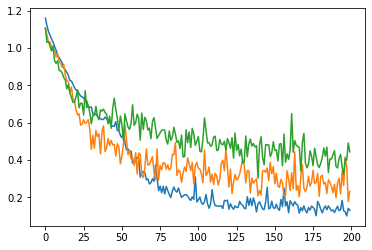

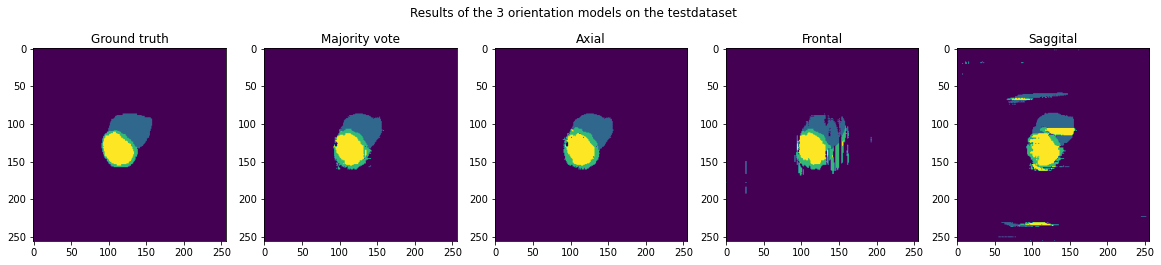

In [3]:
"""
Running environment

Here we define the transformations for the training data of the models in each plane:
ax = axial plane
fron = frontal plane
sag = saggital plane

Output of this block:
- validation loss of axial, frontal and saggital model
- dice score of a patient for axial and majority vote model
- visualisation of the ground truth of a 2D mask with predictions of all 4 models
"""
# make output deterministic for reproducibility
monai.utils.set_determinism(seed=0, additional_settings=None)
# make list of training data
train_dict_list = build_heart_data(data_path, mode='train')

# transformations on axial plane
train_transform_ax = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=(256,256,1), random_size=False), #Random slice transverse
        monai.transforms.SqueezeDimd(keys=['img', 'mask'],dim = -1), #Random slice transverse
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.RandRotate90d(keys = ['img','mask'],prob=0.5, max_k=1),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256), size_mode='all', mode=['area','nearest'], align_corners=None),
        ]
)


# transformations on frontal plane
train_transform_fron = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.RandCropByPosNegLabeld(keys = ['img','mask'], spatial_size=(256,1,256),label_key='mask',neg=0.2,num_samples=1, allow_smaller=True), #Random slice transverse
        monai.transforms.SqueezeDimd(keys=['img', 'mask'],dim = -2), #Random slice transverse 
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.RandRotate90d(keys = ['img','mask'],prob=0.5, max_k=1),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256), size_mode='all', mode=['area','nearest'], align_corners=None),
        ]
)


# transformations on saggital plane
train_transform_sag = monai.transforms.Compose(
    [
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.RandCropByPosNegLabeld(keys = ['img','mask'], spatial_size=(1,256,256),label_key='mask',neg=0.2,num_samples=1, allow_smaller=True),
        monai.transforms.SqueezeDimd(keys=['img', 'mask'],dim = -3),#Random saggital
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.RandRotate90d(keys = ['img','mask'],prob=0.5, max_k=1),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256), size_mode='all', mode=['area','nearest'], align_corners=None),
        ]
)


# Transformations on test data
test_dict = build_heart_data(data_path, mode='test')
test_transform = monai.transforms.Compose([
        monai.transforms.LoadImaged(keys=['img', 'mask']),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        monai.transforms.AsDiscreted(keys = ['mask'], to_onehot=4),
        monai.transforms.Resized(keys = ['img','mask'],spatial_size=(256, 256,256), size_mode='all', mode=['area','nearest'], align_corners=None),
    ]
)

test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)


#We train the 3 models in axial, frontal and saggital plane
epochs = 200
model_ax = modeltrain(train_transform_ax,epochs)
model_fron = modeltrain(train_transform_fron,epochs)
model_sag = modeltrain(train_transform_sag,epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#We apply the 3 models to the test data
maskoutput3d_ax = test_model(model_ax)
maskoutput3d_ax = np.swapaxes(maskoutput3d_ax, 1, 1)

maskoutput3d_fron = test_model(model_fron)
maskoutput3d_fron = np.swapaxes(maskoutput3d_fron, 2, 3)

maskoutput3d_sag = test_model(model_sag)
maskoutput3d_sag = np.swapaxes(maskoutput3d_sag, 2,3)
maskoutput3d_sag = np.swapaxes(maskoutput3d_sag, 2,1)

#We combine the 3 models to get a majority vote model
majority_vote_list = majorityvote(maskoutput3d_ax, maskoutput3d_fron, maskoutput3d_sag)

#Create list of ground truth masks
ground_truth_mask_list = ground_truth_masks(test_loader)

#Visualize slice 128 of patient 0 for different models
visualize_slice(majority_vote_list, maskoutput3d_ax, maskoutput3d_fron, maskoutput3d_sag, 0, 128, ground_truth_mask_list)
#Compute Dice
majority_vote_dicelist = dice_score(ground_truth_mask_list,majority_vote_list,0)
ax_dicelist = dice_score(ground_truth_mask_list,maskoutput3d_ax,0)

print("The majority vote model has the following dice scores [yellow, green, blue] \r\n",majority_vote_dicelist)
print("The axial model has the following dice scores [yellow, green, blue] \r\n",ax_dicelist)

#ONLY RUN WHEN YOU HAVE REMOVED ALL 'break' STATEMENTS
# Change removebreakstatements to '1'
#Compute Mean Dice
removebreakstatements = 0
if removebreakstatements == 1:
  sumscores = [0,0,0]
  for i in range(0,9):
    score = dice_score(ground_truth_mask_list,majority_vote_list,i)
    sumscores = [sum(value) for value in zip(sumscores, score)]
  meandice_majority_vote = np.divide(sumscores,9)
  print(meandice_majority_vote)